# Interaction between characters

In [1]:
import sys
sys.path.insert(1, '../src')

from book_entities import *
from book_entities_embeddings_getters import *

## Book entities

In [2]:
# cleaned entities
textually_close_merged_book_cleaned_entities, lax_merged_book_cleaned_entities = get_book_entities(
    f'../data/book_entities/grouped_token_cleaned.csv')

In [3]:
for idx, i in enumerate(textually_close_merged_book_cleaned_entities) :
    print(idx,BookEntity.from_list_entity(i).get_shortname())

0 Comte Altamira
1 Amanda
2 M Appert
3 Bonaparte
4 Abbé Castanède
5 Caylus
6 Abbé Chélan
7 Croisenois
8 Danton
9 Mme Derville
10 M Descoulis
11 Dieu
12 Falcoz
13 M Fouqué
14 Vicaire Frilair
15 Geronimo
16 Abbé Julien Sorel
17 Mole Mathilde
18 Prince Korasoff
19 Estime
20 Père Marquis
21 Vicaire Maslon
22 Général Napoléon
23 Comte Norbert
24 M Pirard
25 Pitt
26 M Rênal
27 Mme Rênal
28 Mère Stanislas
29 Père Stanislas
30 M Tanbeau
31 M Valenod
32 Élisa


## Paragraphs

In [4]:
from bs4 import BeautifulSoup

In [5]:
# Reading the data inside the xml
# file to a variable under the name
# data
with open('../data/book/stendhal_rougenoir_xml.xml', 'r') as f:
	data = f.read()

In [6]:
# Passing the stored data inside
# the beautifulsoup parser, storing
# the returned object
Bs_data = BeautifulSoup(data, "xml")

In [7]:
paragraphs = []
for tag in Bs_data.find_all('p') :
    if tag.name == 'p' and not ('rend' in tag.attrs) :
        paragraphs.append(tag.get_text())

### dialogue et narration

In [8]:
narration = []
temp_dialogue = []
for p in paragraphs :
    if isinstance(p, str) :
        if p[0] == '–' :
            temp_dialogue.append(p)
        else :
            if len(temp_dialogue)>0 :
                narration.append(' '.join(temp_dialogue))
                temp_dialogue=[]
            narration.append(p)
        

pour chaque paragraphe chercher si il contient une entité, puis regarder toutes les entités qu'il contient 



### narration

In [9]:
def process_paragraph(p) :
    
    pattern1 = r"""[,.;@#?!&$\s:–]+"""
    pattern2 = r"""[-'’_]"""

    p = re.sub(r'|'.join((pattern1, pattern2)),
               " ",          # and replace it with a single space
               p.replace('\xa0', ' '), flags=re.VERBOSE)
    return [i.lower() for i in p.split(' ')[:-1] if i.lower() not in french_stopwords]

In [10]:
def entity_in_paragraph(entity, paragraph):
    return [1 for address in entity.all_addresses if all(x.lower() in p for x in address.lower().split(' '))]

In [11]:
dict_interaction = {}
for paragraph in narration :
    p = process_paragraph(paragraph)
    paragraph_entities = [
        i for i in textually_close_merged_book_cleaned_entities if entity_in_paragraph(i, p)]
    
    if len(paragraph_entities)>=2 :
        key = frozenset(paragraph_entities)
        value = dict_interaction.get(key,[])
        value.append(p)
        dict_interaction[key] = value

In [12]:
len(dict_interaction)

199

## DataFrame of Interactions

In [13]:
entities = []
interactions = []
for k, v in dict_interaction.items() :
    entities.append([BookEntity.from_list_entity(ent).get_shortname() for ent in k])
    interactions.append(v)
    
interactions_df = pd.DataFrame({'entities':entities, 'interactions' : interactions})

In [14]:
interactions_df.head()

,entities,interactions
0,"[Abbé Julien Sorel, M Rênal]","[[attendez, point, trouver, france, jardins, p..."
1,"[M Rênal, Vicaire Maslon]","[[trouve, chose, reprendre, cours, fidelite, l..."
2,"[Mme Rênal, M Rênal]","[[jour, automne, m, rênal, promenait, cours, f..."
3,"[M Valenod, M Rênal, Abbé Chélan]","[[faits, commentés, exagérés, façons, agitaien..."
4,"[M Valenod, M Rênal]","[[reproches, m, rênal, m, valenod, directeur, ..."


In [15]:
interactions_df['nber_interactions']= interactions_df.interactions.apply(lambda x : len(x))
interactions_df.head()

,entities,interactions,nber_interactions
0,"[Abbé Julien Sorel, M Rênal]","[[attendez, point, trouver, france, jardins, p...",50
1,"[M Rênal, Vicaire Maslon]","[[trouve, chose, reprendre, cours, fidelite, l...",1
2,"[Mme Rênal, M Rênal]","[[jour, automne, m, rênal, promenait, cours, f...",12
3,"[M Valenod, M Rênal, Abbé Chélan]","[[faits, commentés, exagérés, façons, agitaien...",1
4,"[M Valenod, M Rênal]","[[reproches, m, rênal, m, valenod, directeur, ...",8


In [16]:
interactions_df = interactions_df.sort_values(by = 'nber_interactions', ascending = False)

### embeddings of interactions

In [17]:
model_name = 'flaubert/flaubert_base_cased' 

# Load pretrained model and tokenizer
flaubert, log = FlaubertModel.from_pretrained(model_name, output_loading_info=True)
flaubert_tokenizer = FlaubertTokenizer.from_pretrained(model_name, do_lowercase=False)

def from_interaction_to_embeddings (list_interactions) :
    embeddings = []
    for interaction in list_interactions :
        token_ids = torch.tensor([flaubert_tokenizer.encode(interaction)])
        last_layer = flaubert(token_ids)[0][:,1:-1, :]

        # possibilité de faire d'autres opérations
        # embeddings.append(torch.mean(last_layer, dim = 1).detach().numpy()[0])
        embeddings.append(last_layer.detach().numpy())
    return embeddings

interactions_df['embeddings'] = interactions_df.interactions.apply(
    lambda x : from_interaction_to_embeddings(x))
                                                             

Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing FlaubertModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing FlaubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [94]:
renal_sorel = interactions_df.iloc[0].embeddings

In [98]:
interactions_df.entities.head()

16              [Abbé Julien Sorel, Mme Rênal]
107         [Abbé Julien Sorel, Mole Mathilde]
0                 [Abbé Julien Sorel, M Rênal]
77               [Abbé Julien Sorel, M Pirard]
17     [Abbé Julien Sorel, Mme Rênal, M Rênal]
Name: entities, dtype: object

In [99]:
mole_sorel = interactions_df.iloc[1].embeddings

## PCA

In [19]:
from sklearn.decomposition import PCA

In [95]:
renal_sorel_pca = []
for emb in tqdm(renal_sorel) :
    pca = PCA(n_components=2, svd_solver = 'arpack')
    temp = pd.DataFrame(emb[0])
    components = pca.fit_transform(temp)
    renal_sorel_pca.append(components)

100%|███████████████████████████████████████████████████████████| 121/121 [00:05<00:00, 22.84it/s]


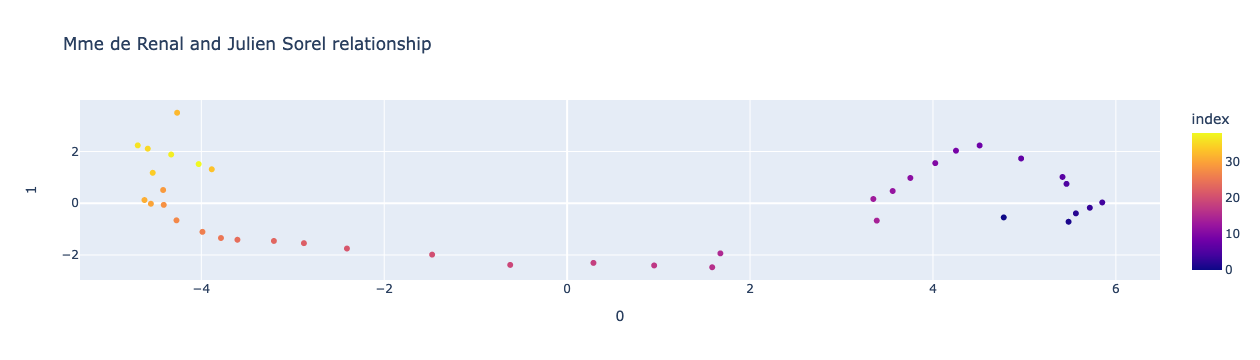

In [96]:
temp = pd.DataFrame(renal_sorel_pca[0])
fig = px.scatter(temp, x = 0, y = 1, color=temp.index, title = 'Mme de Renal and Julien Sorel relationship')
fig.show()

In [105]:
mole_sorel_pca = []
for emb in tqdm(mole_sorel) :
    pca = PCA(n_components=2, svd_solver = 'arpack')
    temp = pd.DataFrame(emb[0])
    components = pca.fit_transform(temp)
    mole_sorel_pca.append(components)

100%|███████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 21.03it/s]


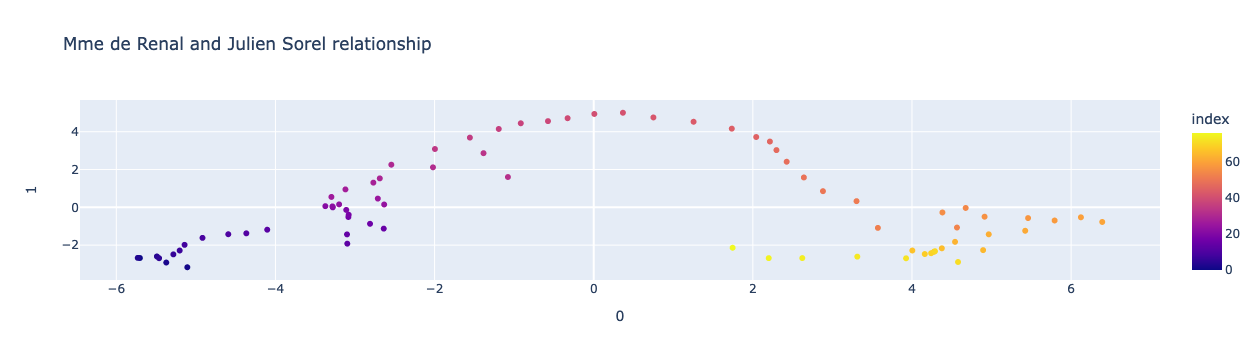

In [106]:
temp = pd.DataFrame(mole_sorel_pca[0])
fig = px.scatter(temp, x = 0, y = 1, color=temp.index, title = 'Mathilde de la Mole and Julien Sorel relationship')
fig.show()

In [107]:
renal_m_sorel = interactions_df.iloc[2].embeddings

In [108]:
renal_m_sorel_pca = []
for emb in tqdm(renal_m_sorel) :
    pca = PCA(n_components=2, svd_solver = 'arpack')
    temp = pd.DataFrame(emb[0])
    components = pca.fit_transform(temp)
    renal_m_sorel_pca.append(components)

100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.76it/s]


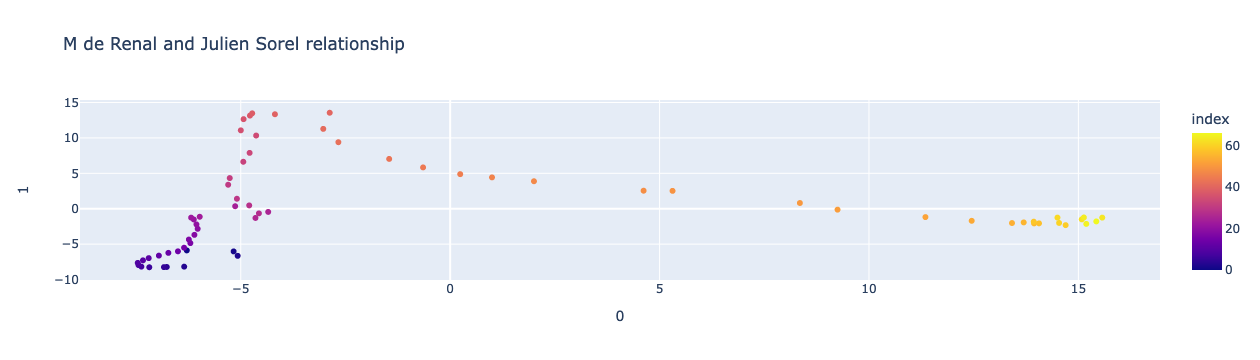

In [109]:
temp = pd.DataFrame(renal_m_sorel_pca[0])
fig = px.scatter(temp, x = 0, y = 1, color=temp.index, title = 'M de Renal and Julien Sorel relationship')
fig.show()